In [1]:
# ======================================================================= #
# Course: Deep Learning Complete Course (CS-501)
# Author: Dr. Saad Laouadi
# Lesson: Deep Learning Regression Tutorial
#
# Description: Training Linear Regression with Keras 3 API
#    """
#    Project Description:
#    ------------------
#    This notebook demonstrates how to build a deep learning regression model using TensorFlow/Keras.
#    We'll generate synthetic data using scikit-learn, then build, train, and evaluate a neural network
#    for regression tasks. This tutorial is designed for educational purposes to help understand the
#    complete workflow of creating deep learning models for regression problems.
#
#    Objectives:
#    ----------
#    1. Learn how to generate synthetic regression data
#    2. Understand deep learning model architecture for regression
#    3. Learn the proper steps for data preprocessing
#    4. Build and compile a neural network using Keras
#    5. Train and evaluate the model's performance
#    6. Visualize the results and model predictions
#    """
# =======================================================================
#.          Copyright © Dr. Saad Laouadi 2024
# =======================================================================

In [46]:
# 1. Environment Setup
# ------------------
import os  
import sys 
from pathlib import Path
from pprint import pprint

# Disable Metal API Validation
os.environ["METAL_DEVICE_WRAPPER_TYPE"] = "0"

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2


print("="*72)

%reload_ext watermark
%watermark -a "Dr. Saad Laouadi" -u -d -m

print("="*72)
print("Imported Packages and Their Versions:")
print("="*72)

%watermark -iv
print("="*72)

Author: Dr. Saad Laouadi

Last updated: 2024-11-30

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Imported Packages and Their Versions:
numpy     : 1.26.4
tensorflow: 2.16.2
matplotlib: 3.9.2
sklearn   : 1.5.1
sys       : 3.11.10 (main, Oct  3 2024, 02:26:51) [Clang 14.0.6 ]
keras     : 3.6.0
pandas    : 2.2.2



In [47]:
# 2. Data Generation Function
# -------------------------
def generate_regression_data(n_samples=1000, n_features=1, noise=20.0, random_state=42):
    """
    Generate synthetic regression data using sklearn's make_regression.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_features : int
        Number of features (independent variables)
    noise : float
        Standard deviation of gaussian noise
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X : ndarray of shape (n_samples, n_features)
        Generated samples
    y : ndarray of shape (n_samples,)
        Target values
    """
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        noise=noise,
        random_state=random_state
    )
    
    # Reshape y to be a column vector
    y = y.reshape(-1, 1)
    
    return X, y

# Normalize the data
def normalize_data(df):
    """
    Normalize the features and target using StandardScaler.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing features and target
    
    Returns:
    --------
    X_scaled : numpy array
        Normalized features
    y_scaled : numpy array
        Normalized target
    scalers : tuple
        (X_scaler, y_scaler) for inverse transformation if needed
    """
    # Separate features and target
    X_data = df.drop('Y', axis=1)
    y_data = df['Y']
    
    # Create scalers
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    # Fit and transform the data
    X_scaled = X_scaler.fit_transform(X_data)
    y_scaled = y_scaler.fit_transform(y_data.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, (X_scaler, y_scaler)


def normalize_features_split(X_train, X_test):
    """
    Normalize features using StandardScaler after splitting.
    Fits on training data and transforms both training and test data.
    
    Parameters:
    -----------
    X_train : numpy array or DataFrame
        Training features
    X_test : numpy array or DataFrame
        Test features
    
    Returns:
    --------
    X_train_scaled : numpy array
        Normalized training features
    X_test_scaled : numpy array
        Normalized test features
    scaler : StandardScaler
        Fitted scaler for future transformations
    """
    # Create scaler
    scaler = StandardScaler()
    
    # Fit and transform training data
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Transform test data using training fit
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, scaler

# Regression Evaluation Metrics
def evaluate_regression_metrics(y_true, y_pred):
    """
    Calculate common regression metrics
    """
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")

In [48]:
# Generate random data
X, y = generate_regression_data(n_samples=10000, n_features=3, random_state=101)
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (10000, 3)
Target shape: (10000, 1)


In [49]:
# Check the data description 
df = pd.DataFrame(data = np.concatenate([X, y], axis = 1),
                  columns = [f"X_{i}" for i in range(1,4)]+['Y']
                 )

In [50]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X_1,10000.0,-0.001262,0.994194,-3.806886,-0.674393,0.001271,0.676238,4.155123
X_2,10000.0,-0.004265,1.007255,-3.756504,-0.680627,-0.008693,0.678417,4.651961
X_3,10000.0,0.006563,0.996595,-3.919881,-0.665755,0.005914,0.666455,4.260621
Y,10000.0,0.453045,110.003277,-444.537202,-74.224674,-0.384304,74.285186,403.351975


In [51]:
# Split the data into training and testing sets
# First, split into train and test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,  # Reserve 30% for validation + test
    random_state=101
)

# Second, split the temporary set into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # Split the remaining 30% equally
    random_state=101
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

The X train set shape: (8000, 3)
The X test set shape: (2000, 3)
The y train set shape: (8000, 1)
The y test set shape: (2000, 1)


In [52]:
# Apply normalization to our split data
X_train_scaled, X_test_scaled, scaler = normalize_features_split(X_train, X_test)

In [56]:
# Advanced Regression Model Structure
# ---------------------------------

def create_advanced_model(input_dim, 
                        dropout_rate=0.3,
                        l2_reg=0.01):
    """
    Create a more sophisticated regression model with:
    - Wider layers at start, gradually narrowing
    - Batch Normalization for better training
    - Dropout for regularization
    - L2 regularization on weights
    - Residual connections
    """
    
    # Input Layer
    inputs = Input(shape=(input_dim,), name='input_layer')
    
    # First Block
    x = Dense(256, kernel_regularizer=l2(l2_reg), name='dense_1')(inputs)
    x = BatchNormalization(name='batch_norm_1')(x)
    x = Activation('relu', name='activation_1')(x)
    x = Dropout(dropout_rate, name='dropout_1')(x)
    
    # Second Block (with residual connection)
    block_2 = Dense(256, kernel_regularizer=l2(l2_reg), name='dense_2')(x)
    block_2 = BatchNormalization(name='batch_norm_2')(block_2)
    block_2 = Activation('relu', name='activation_2')(block_2)
    block_2 = Dropout(dropout_rate, name='dropout_2')(block_2)
    # Add residual connection
    x = Add()([x, block_2])
    
    # Third Block - Reducing dimensions
    x = Dense(128, kernel_regularizer=l2(l2_reg), name='dense_3')(x)
    x = BatchNormalization(name='batch_norm_3')(x)
    x = Activation('relu', name='activation_3')(x)
    x = Dropout(dropout_rate/2, name='dropout_3')(x)
    
    # Fourth Block - Further reduction
    x = Dense(64, kernel_regularizer=l2(l2_reg), name='dense_4')(x)
    x = BatchNormalization(name='batch_norm_4')(x)
    x = Activation('relu', name='activation_4')(x)
    x = Dropout(dropout_rate/2, name='dropout_4')(x)
    
    # Output Layer
    outputs = Dense(1, name='output')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='advanced_regression')
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='advanced_regression')
    
    # Compile with fixed learning rate instead of schedule
    optimizer = Adam(learning_rate=0.001)  # Fixed learning rate
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [57]:
# Training with proper callbacks
def train_advanced_model(model, X_train, y_train, X_val, y_val):
    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    # Reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    # Model checkpoint
    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=1
    )
    
    return history

In [58]:
# Train the model
model = create_advanced_model(X_train_scaled.shape[1])
history = train_advanced_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

Epoch 1/100
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10674.6094 - mae: 82.6004
Epoch 1: val_loss improved from inf to 9316.20898, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 10664.9863 - mae: 82.5653 - val_loss: 9316.2090 - val_mae: 78.6799 - learning_rate: 0.0010
Epoch 2/100
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7216.7607 - mae: 68.0372
Epoch 2: val_loss improved from 9316.20898 to 3190.29395, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 7199.8613 - mae: 67.9499 - val_loss: 3190.2939 - val_mae: 46.6688 - learning_rate: 0.0010
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3662.6721 - mae: 47.3743
Epoch 3: val_loss improved from 3190.29395 to 710.68909, saving model to best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 3660.2817 - mae: 47.3567 - val_loss: 710.6891 - val_mae: 21.2740 - learning_rate: 0.0010
Epoch 4/100
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

In [61]:
model.evaluate(X_test_scaled, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 385.3754 - mae: 15.4700


[403.0937194824219, 15.889397621154785]

In [62]:
# Make predictions
y_pred = model.predict(X_test, verbose=0)

# Calculate metrics
metrics = {
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse':root_mean_squared_error(y_test, y_pred),
    'r2': r2_score(y_test, y_pred)
}

In [63]:
metrics

{'mae': 15.898946382627768,
 'rmse': 19.93606401841813,
 'r2': 0.9673573804059081}

In [71]:
def plot_training_history(history):
    """
    Visualize training metrics including loss, MAE, and learning rate changes.
    
    Parameters:
    -----------
    history : keras.callbacks.History
        The history object returned from model.fit()
    """
    # Create subplots
    plt.figure(figsize=(15, 5))
    
    # 1. Plot Training and Validation Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    
    # 2. Plot Training and Validation MAE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)
    
    # 3. Plot Learning Rate changes
    plt.subplot(1, 3, 3)
    plt.plot(history.history['learning_rate'], label='Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')  # Log scale for better visualization
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print training summary
    print("\nTraining Summary:")
    print(f"Number of epochs trained: {len(history.history['loss'])}")
    print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
    print(f"Best validation MAE: {min(history.history['val_mae']):.4f}")
    print(f"Initial learning rate: {max(history.history['learning_rate']):.6f}")
    print(f"Final learning rate: {min(history.history['learning_rate']):.6f}")
    
    # Find where best model occurred
    best_epoch = np.argmin(history.history['val_loss']) + 1
    print(f"Best model found at epoch {best_epoch}")

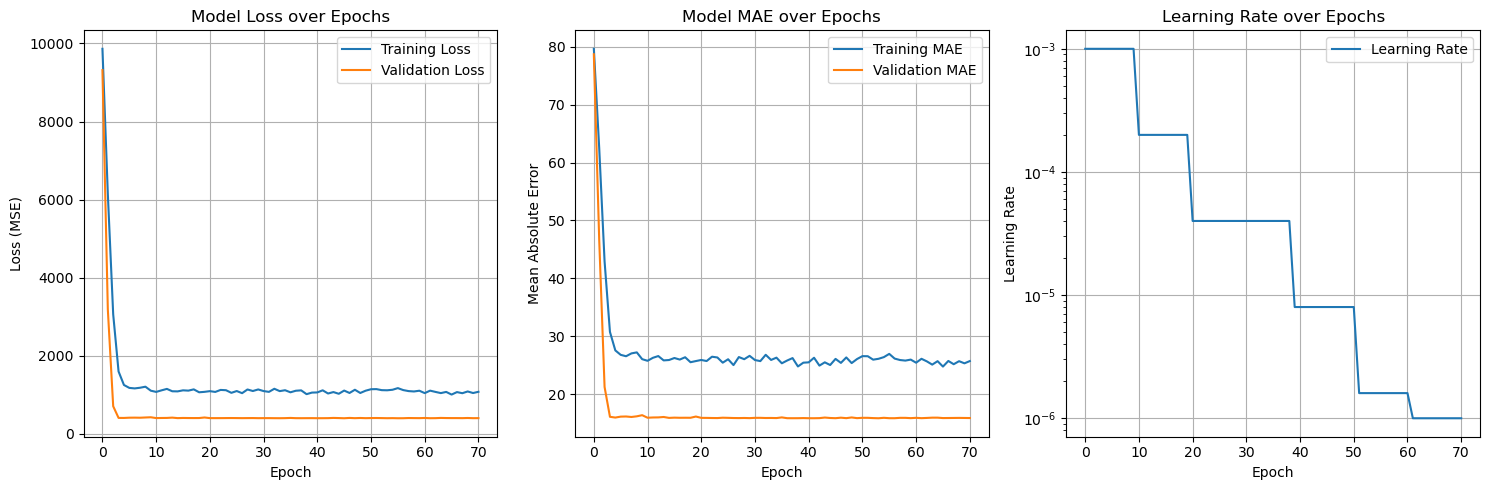


Training Summary:
Number of epochs trained: 71
Best validation loss: 403.0937
Best validation MAE: 15.8788
Initial learning rate: 0.001000
Final learning rate: 0.000001
Best model found at epoch 56


In [73]:
# Plot the history parameters
plot_training_history(history)